![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


## Read in the csv file rental_info.csv using pandas.

In [22]:
# read the dataset
df = pd.read_csv("rental_info.csv", parse_dates=["rental_date", "return_date"])
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [23]:
# look at df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   rental_date       15861 non-null  datetime64[ns, UTC]
 1   return_date       15861 non-null  datetime64[ns, UTC]
 2   amount            15861 non-null  float64            
 3   release_year      15861 non-null  float64            
 4   rental_rate       15861 non-null  float64            
 5   length            15861 non-null  float64            
 6   replacement_cost  15861 non-null  float64            
 7   special_features  15861 non-null  object             
 8   NC-17             15861 non-null  int64              
 9   PG                15861 non-null  int64              
 10  PG-13             15861 non-null  int64              
 11  R                 15861 non-null  int64              
 12  amount_2          15861 non-null  float64            
 13  l

## Create a column named "rental_length_days" using the columns "return_date" and "rental_date", and add it to the pandas DataFrame. This column should contain information on how many days a DVD has been rented by a customer.

In [24]:
df["rental_length_days"] = (df["return_date"] - df["rental_date"]).dt.days
df["rental_length_days"].head()

0    3
1    2
2    7
3    2
4    4
Name: rental_length_days, dtype: int64

## Create two columns of dummy variables from "special_features", which takes the value of 1 when:
The value is "Deleted Scenes", storing as a column called "deleted_scenes".\
The value is "Behind the Scenes", storing as a column called "behind_the_scenes".

In [25]:
print(df["special_features"].unique())

['{Trailers,"Behind the Scenes"}' '{Trailers}'
 '{Commentaries,"Behind the Scenes"}' '{Trailers,Commentaries}'
 '{"Deleted Scenes","Behind the Scenes"}'
 '{Commentaries,"Deleted Scenes","Behind the Scenes"}'
 '{Trailers,Commentaries,"Deleted Scenes"}' '{"Behind the Scenes"}'
 '{Trailers,"Deleted Scenes","Behind the Scenes"}'
 '{Commentaries,"Deleted Scenes"}' '{Commentaries}'
 '{Trailers,Commentaries,"Behind the Scenes"}'
 '{Trailers,"Deleted Scenes"}' '{"Deleted Scenes"}'
 '{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}']


In [26]:
df['deleted_scenes'] = df['special_features'].apply(lambda x: 1 if "Deleted Scenes" in x else 0)
df['behind_the_scenes'] = df['special_features'].apply(lambda x: 1 if "Behind the Scenes" in x else 0)
print(df["deleted_scenes"].nunique())
print(df["behind_the_scenes"].nunique())

2
2


# data cleaning

In [27]:
# look at the dataframe info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   rental_date         15861 non-null  datetime64[ns, UTC]
 1   return_date         15861 non-null  datetime64[ns, UTC]
 2   amount              15861 non-null  float64            
 3   release_year        15861 non-null  float64            
 4   rental_rate         15861 non-null  float64            
 5   length              15861 non-null  float64            
 6   replacement_cost    15861 non-null  float64            
 7   special_features    15861 non-null  object             
 8   NC-17               15861 non-null  int64              
 9   PG                  15861 non-null  int64              
 10  PG-13               15861 non-null  int64              
 11  R                   15861 non-null  int64              
 12  amount_2            15861 non-nu

In [28]:
# look for all object colunms
for col in df.columns:
    if df[col].dtype == object:
        print(col)

special_features


In [29]:
df["special_features"].nunique()

15

In [30]:
# we do not need the "special_features" column so drop it
df = df.drop("special_features", axis=1)
df.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,3,0,1
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,0,1
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,7,0,1
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,2,0,1
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,0,0,0,1,8.9401,15876.0,8.9401,4,0,1


In [31]:
# check for any missing values (no missing values)
df.isnull().sum().sum()

0

In [32]:
# Make X, y variabels
X = df.drop(["rental_date", "return_date", "rental_length_days"], axis=1)
y = df["rental_length_days"]

In [33]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=9)

# Aplly the models 

In [34]:
# Initialize the models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=9),
    "SVM": SVR(),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=9)
}

# Train each model and calculate MSE
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} MSE: {mse}")

Linear Regression MSE: 2.874977484385886
Decision Tree MSE: 2.2174601075582325
SVM MSE: 7.030137454182352
KNN MSE: 2.734736842105263
Random Forest MSE: 2.081888179154513


## there are 4 models that yielding a mean squared error (MSE) less than 3 
1- Linear Regression.\
2- Decision Tree.\
3- KNN.\
4- Random Forest.

## but the best of them is Random Forest and is kinda predicted to yields the least MSE becouse it considerd as ensemble learning model which reduce the variance and maximize the preformance

In [35]:
best_model = RandomForestRegressor(random_state=9)
best_mse = 2.081

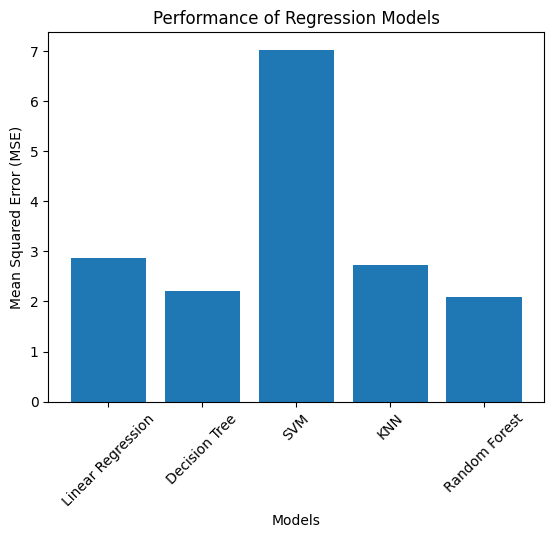

In [36]:
# make visualization of all models performance

mse_values = []
model_names = []

# Calculate MSE for each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)
    model_names.append(name)

# Plot the MSE values
plt.bar(model_names, mse_values)
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Performance of Regression Models')
plt.xticks(rotation=45)
plt.show()

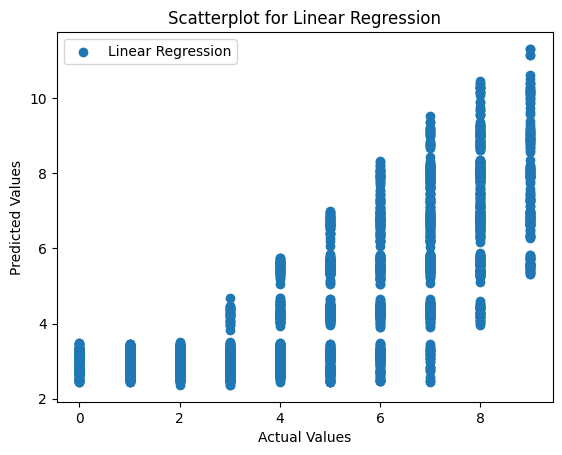

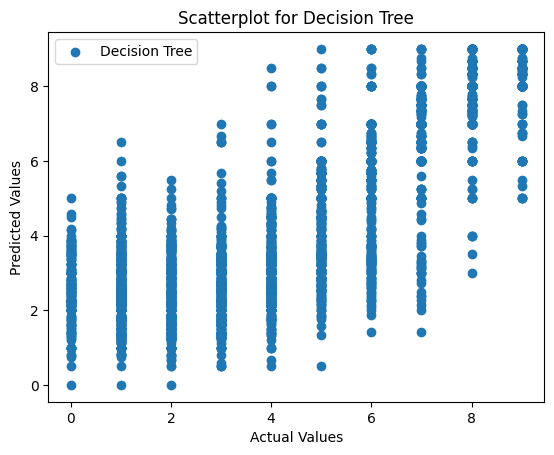

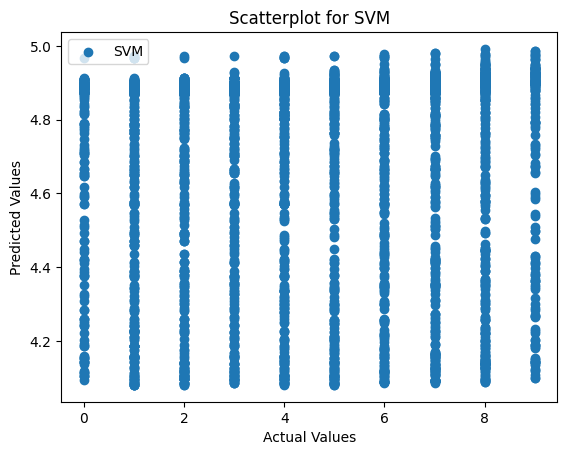

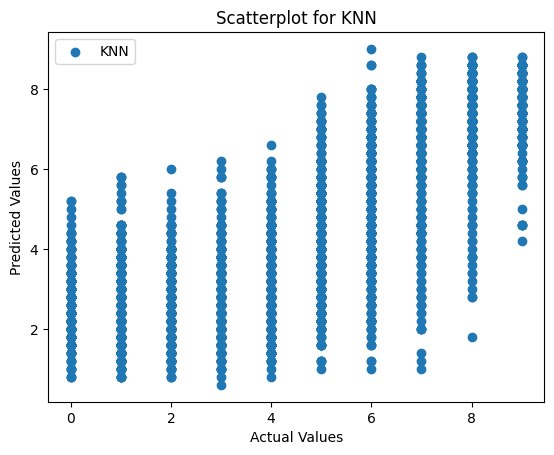

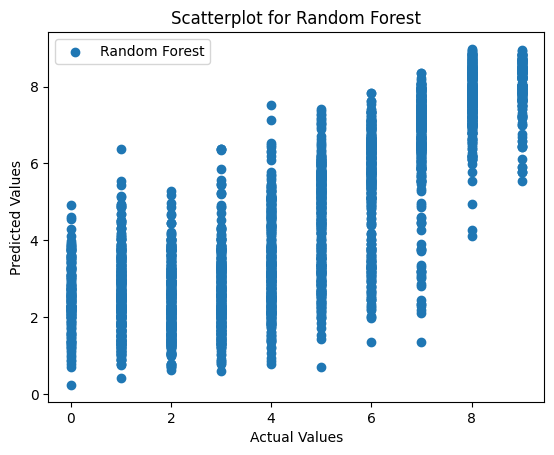

In [37]:
# make scatterplot for each model saparated to the actual and predicted values

# Plot scatterplots for each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    plt.scatter(y_test, y_pred, label=name)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Scatterplot for {name}')
    plt.legend()
    plt.show()